In [10]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_default_device", jax.devices()[0])
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from importlib import reload
# import KernelTools
# reload(KernelTools)
from KernelTools import *
# from EquationModel import InducedRKHS,OperatorModel,CholOperatorModel
from EquationModel import CholInducedRKHS, OperatorPDEModel, OperatorModel
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data
)
from Kernels import log1pexp,inv_log1pexp, get_gaussianRBF
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from Optimizers import (CholeskyLM, 
                        SVD_LM,
                        LMParams,
                        plot_optimization_results)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results, get_nrmse    
from matplotlib import ticker
plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

In [11]:
# coeffs of Burgers eqn
kappa = 0.001
alpha = 5.
# IC
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0
# solve Burgers eqn                            
u_true_function,ut_true_function,interp,t_vals,sols = (
    build_burgers_data(func_u0=func_u0,
                        kappa = kappa,
                        alpha = alpha,
                        k_timestep=0.0001,
                        n_finite_diff=1999)
)

  0%|          | 0/10099 [00:00<?, ?it/s]

100%|██████████| 10099/10099 [00:03<00:00, 2613.76it/s]


In [12]:
# size of coll grid
num_grid_x, num_grid_t = 31, 26

# get interior and bdry pts of coll grid
tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],
                                        num_grid_t,
                                        num_grid_x,
                                        alpha = 0.5
)

# coll grid and obs grid
seed = 55
n_obs = 60
tx_all, tx_obs = setup_problem_data(tx_int,
                                    tx_bdy,
                                    n_obs,
                                    jax.random.PRNGKey(seed),
                                    times_to_observe = (0,)
)

# u vals at coll grid
u_all = u_true_function(tx_all)

# u vals at obs grid
u_obs = u_true_function(tx_obs)

In [13]:
# fine grid
num_fine_grid = 300
t_fine, x_fine = jnp.meshgrid(jnp.linspace(0,1,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
# u vals at fine grid
u_true = u_true_function(tx_fine)

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

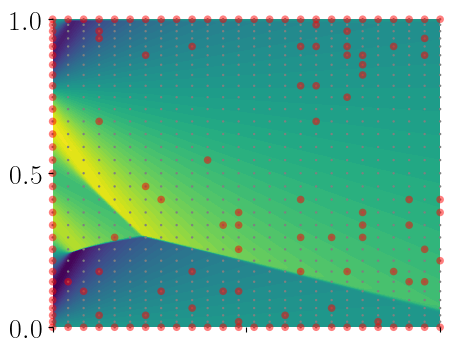

In [14]:
# u_true plot
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, u_true,
                levels= 70, 
                vmin=-0.453787655164269,
                vmax=0.3887784971499098)
# coll grid
plt.scatter(*tx_all.T,
            c='gray',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')
# obs grid
plt.scatter(*tx_obs.T,
            c='red', 
            s = 30, 
            alpha = 0.5,
            clip_on =False,
            edgecolors = 'none')

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([])
plt.gca().set_xticklabels([]) 

In [15]:
# x fine grid
xfine = jnp.linspace(0,1,num_fine_grid)
# u vals at fine grid at IC
u_true_IC = u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid), xfine]).T)
# u vals at fine grid at FC
u_true_FC = u_true_function(jnp.vstack([1.0*jnp.ones(num_fine_grid), xfine]).T)

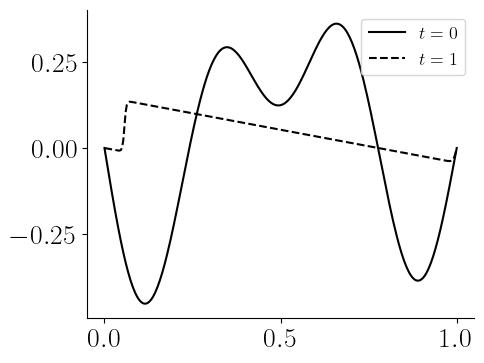

In [16]:
# u_true IC and FC plot
plt.figure(figsize=(5,4))
# Plot IC
plt.plot(xfine, u_true_IC,
         color = 'black',
         label = r'$t=0$')
# Plot FC
plt.plot(xfine,u_true_FC,
         linestyle = '--',
         color = 'black',
         label = r'$t=1$')

# fig settings
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc="upper right",fontsize = 13)

In [17]:
# u basis ops
u_operators = (eval_k,dx_k,dt_k)
# L ops
feature_operators = (eval_k,dx_k,dxx_k)

# u kernel that also depends on params
def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)
# u fitted hyper-params: MLE
fitted_params, ml_value = fit_kernel_params(param_ani_gaussian_RBF,
                                            tx_obs,
                                            u_obs,
                                            jnp.zeros(2))
MLE_lengthscales = log1pexp(fitted_params)
# print(1/(jnp.sqrt(MLE_lengthscales)))

# u kernel
k_u = get_anisotropic_gaussianRBF(0.75,jnp.diag(log1pexp(fitted_params)))
# u RKHS
u_model = CholInducedRKHS(tx_all,
                          u_operators,
                          k_u,
                          nugget_size = 1e-8
)
# u fitted params
u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

In [18]:
# u_pred vals at fine grid
u_pred = u_model.point_evaluate(tx_fine,u_params_init)

# u error at fine grid
print(get_nrmse(u_true,u_pred))

0.6283368815372552


[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

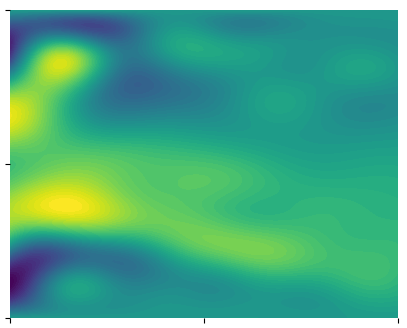

In [19]:
# u_pred plot
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, u_pred,
                levels= 70, 
                vmin =-0.453787655164269,
                vmax=0.3887784971499098)

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([]) 
plt.gca().set_yticklabels([])

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

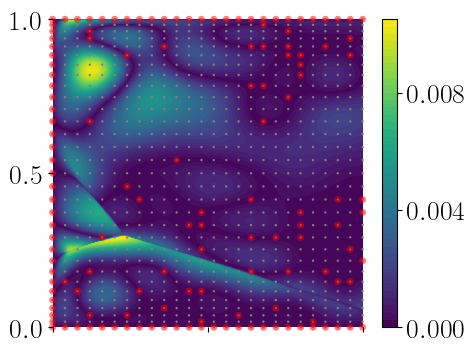

In [20]:
# u errors plot
plt.figure(figsize=(5,4))
cp = plt.tricontourf(*tx_fine.T, jnp.abs(u_true - u_pred)/jnp.linalg.norm(u_true),
                levels= 50)
# coll grid
plt.scatter(*tx_all.T,
            c='gray',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')
# obs grid
plt.scatter(*tx_obs.T,
            c='red', 
            s = 25, 
            alpha = 0.5,
            clip_on =False,
            edgecolors = 'none')

# colorbar
cb = plt.colorbar(cp)

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_xticklabels([])

In [21]:
# store data
data = {'tx_obs': tx_obs,
        'tx_all': tx_all,
        'tx_int': tx_int,
        'tx_bdy': tx_bdy,
        'tx_fine': tx_fine,
        'xfine': xfine,
        'u_true': u_true,
        'u_pred': u_pred,
        'u_true_IC': u_true_IC,
        'u_true_FC': u_true_FC
}

In [22]:
# save data
np.save('data.npy', np.array(data, dtype=object), allow_pickle=True)